## Now we do enter the genetic alg.  

To make it modular, we will have multiple classes. Some are already made by Valerio, but others must be created to modulate the rules easily.     



--- 
# Libraries

In [5]:
import random
from dataclasses import dataclass

import music21

---    
# Code 

In [6]:
@dataclass(frozen=True)
class MelodyData:
    """
    A data class representing the data of a melody.

    This class encapsulates the details of a melody including its notes, total
    duration, and the number of bars. The notes are represented as a list of
    tuples, with each tuple containing a pitch and its duration. The total
    duration and the number of bars are computed based on the notes provided.

    Attributes:
        notes (list of tuples): List of tuples representing the melody's notes.
            Each tuple is in the format (pitch, duration).
        duration (int): Total duration of the melody, computed from notes.
        number_of_bars (int): Total number of bars in the melody, computed from
            the duration assuming a 4/4 time signature.

    Methods:
        __post_init__: A method called after the data class initialization to
            calculate and set the duration and number of bars based on the
            provided notes.
    """

    notes: list
    duration: int = None  # Computed attribute
    number_of_bars: int = None  # Computed attribute

    def __post_init__(self):
        object.__setattr__(
            self, "duration", sum(duration for _, duration in self.notes)
        )
        object.__setattr__(self, "number_of_bars", self.duration // 4)


In [7]:
class GeneticMelodyHarmonizer:
    """
    Generates chord accompaniments for a given melody using a genetic algorithm.
    It evolves a population of chord sequences to find one that best fits the
    melody based on a fitness function.

    Attributes:
        melody_data (MusicData): Data containing melody information.
        chords (list): Available chords for generating sequences.
        population_size (int): Size of the chord sequence population.
        mutation_rate (float): Probability of mutation in the genetic algorithm.
        fitness_evaluator (FitnessEvaluator): Instance used to assess fitness.
    """

    def __init__(
        self,
        melody_data,
        chords,
        population_size,
        mutation_rate,
        fitness_evaluator,
    ):
        """
        Initializes the generator with melody data, chords, population size,
        mutation rate, and a fitness evaluator.

        Parameters:
            melody_data (MusicData): Melody information.
            chords (list): Available chords.
            population_size (int): Size of population in the algorithm.
            mutation_rate (float): Mutation probability per chord.
            fitness_evaluator (FitnessEvaluator): Evaluator for chord fitness.
        """
        self.melody_data = melody_data
        self.chords = chords
        self.mutation_rate = mutation_rate
        self.population_size = population_size
        self.fitness_evaluator = fitness_evaluator
        self._population = []

    def generate(self, generations=1000):
        """
        Generates a chord sequence that harmonizes a melody using a genetic
        algorithm.

        Parameters:
            generations (int): Number of generations for evolution.

        Returns:
            best_chord_sequence (list): Harmonization with the highest fitness
                found in the last generation.
        """
        self._population = self._initialise_population()
        for _ in range(generations):
            parents = self._select_parents()
            new_population = self._create_new_population(parents)
            self._population = new_population
        best_chord_sequence = (
            self.fitness_evaluator.get_chord_sequence_with_highest_fitness(
                self._population
            )
        )
        return best_chord_sequence

    def _initialise_population(self):
        """
        Initializes population with random chord sequences.

        Returns:
            list: List of randomly generated chord sequences.
        """
        return [
            self._generate_random_chord_sequence()
            for _ in range(self.population_size)
        ]

    def _generate_random_chord_sequence(self):
        """
        Generate a random chord sequence with as many chords as the numbers
        of bars in the melody.

        Returns:
            list: List of randomly generated chords.
        """
        return [
            random.choice(self.chords)
            for _ in range(self.melody_data.number_of_bars)
        ]

    def _select_parents(self):
        """
        Selects parent sequences for breeding based on fitness.

        Returns:
            list: Selected parent chord sequences.
        """
        fitness_values = [
            self.fitness_evaluator.evaluate(seq) for seq in self._population
        ]
        return random.choices(
            self._population, weights=fitness_values, k=self.population_size
        )

    def _create_new_population(self, parents):
        """
        Generates a new population of chord sequences from the provided parents.

        This method creates a new generation of chord sequences using crossover
        and mutation operations. For each pair of parent chord sequences,
        it generates two children. Each child is the result of a crossover
        operation between the pair of parents, followed by a potential
        mutation. The new population is formed by collecting all these
        children.

        The method ensures that the new population size is equal to the
        predefined population size of the generator. It processes parents in
        pairs, and for each pair, two children are generated.

        Parameters:
            parents (list): A list of parent chord sequences from which to
                generate the new population.

        Returns:
            list: A new population of chord sequences, generated from the
                parents.

        Note:
            This method assumes an even population size and that the number of
            parents is equal to the predefined population size.
        """
        new_population = []
        for i in range(0, self.population_size, 2):
            child1, child2 = self._crossover(
                parents[i], parents[i + 1]
            ), self._crossover(parents[i + 1], parents[i])
            child1 = self._mutate(child1)
            child2 = self._mutate(child2)
            new_population.extend([child1, child2])
        return new_population

    def _crossover(self, parent1, parent2):
        """
        Combines two parent sequences into a new child sequence using one-point
        crossover.

        Parameters:
            parent1 (list): First parent chord sequence.
            parent2 (list): Second parent chord sequence.

        Returns:
            list: Resulting child chord sequence.
        """
        cut_index = random.randint(1, len(parent1) - 1)
        return parent1[:cut_index] + parent2[cut_index:]

    def _mutate(self, chord_sequence):
        """
        Mutates a chord in the sequence based on mutation rate.

        Parameters:
            chord_sequence (list): Chord sequence to mutate.

        Returns:
            list: Mutated chord sequence.
        """
        if random.random() < self.mutation_rate:
            mutation_index = random.randint(0, len(chord_sequence) - 1)
            chord_sequence[mutation_index] = random.choice(self.chords)
        return chord_sequence

In [8]:
class FitnessEvaluator:
    """
    Evaluates the fitness of a chord sequence based on various musical criteria.

    Attributes:
        melody (list): List of tuples representing notes as (pitch, duration).
        chords (dict): Dictionary of chords with their corresponding notes.
        weights (dict): Weights for different fitness evaluation functions.
        preferred_transitions (dict): Preferred chord transitions.
    """

    def __init__(
        self, melody_data, chord_mappings, weights, preferred_transitions
    ):
        """
        Initialize the FitnessEvaluator with melody, chords, weights, and
        preferred transitions.

        Parameters:
            melody_data (MelodyData): Melody information.
            chord_mappings (dict): Available chords mapped to their notes.
            weights (dict): Weights for each fitness evaluation function.
            preferred_transitions (dict): Preferred chord transitions.
        """
        self.melody_data = melody_data
        self.chord_mappings = chord_mappings
        self.weights = weights
        self.preferred_transitions = preferred_transitions

    def get_chord_sequence_with_highest_fitness(self, chord_sequences):
        """
        Returns the chord sequence with the highest fitness score.

        Parameters:
            chord_sequences (list): List of chord sequences to evaluate.

        Returns:
            list: Chord sequence with the highest fitness score.
        """
        return max(chord_sequences, key=self.evaluate)

    def evaluate(self, chord_sequence):
        """
        Evaluate the fitness of a given chord sequence.

        Parameters:
            chord_sequence (list): The chord sequence to evaluate.

        Returns:
            float: The overall fitness score of the chord sequence.
        """
        return sum(
            self.weights[func] * getattr(self, f"_{func}")(chord_sequence)
            for func in self.weights
        )

    def _chord_melody_congruence(self, chord_sequence):
        """
        Calculates the congruence between the chord sequence and the melody.
        This function assesses how well each chord in the sequence aligns
        with the corresponding segment of the melody. The alignment is
        measured by checking if the notes in the melody are present in the
        chords being played at the same time, rewarding sequences where the
        melody notes fit well with the chords.

        Parameters:
            chord_sequence (list): A list of chords to be evaluated against the
                melody.

        Returns:
            float: A score representing the degree of congruence between the
                chord sequence and the melody, normalized by the melody's
                duration.
        """
        score, melody_index = 0, 0
        for chord in chord_sequence:
            bar_duration = 0
            while bar_duration < 4 and melody_index < len(
                self.melody_data.notes
            ):
                pitch, duration = self.melody_data.notes[melody_index]
                if pitch[0] in self.chord_mappings[chord]:
                    score += duration
                bar_duration += duration
                melody_index += 1
        return score / self.melody_data.duration

    def _chord_variety(self, chord_sequence):
        """
        Evaluates the diversity of chords used in the sequence. This function
        calculates a score based on the number of unique chords present in the
        sequence compared to the total available chords. Higher variety in the
        chord sequence results in a higher score, promoting musical
        complexity and interest.

        Parameters:
            chord_sequence (list): The chord sequence to evaluate.

        Returns:
            float: A normalized score representing the variety of chords in the
                sequence relative to the total number of available chords.
        """
        unique_chords = len(set(chord_sequence))
        total_chords = len(self.chord_mappings)
        return unique_chords / total_chords

    def _harmonic_flow(self, chord_sequence):
        """
        Assesses the harmonic flow of the chord sequence by examining the
        transitions between successive chords. This function scores the
        sequence based on how frequently the chord transitions align with
        predefined preferred transitions. Smooth and musically pleasant
        transitions result in a higher score.

        Parameters:
            chord_sequence (list): The chord sequence to evaluate.

        Returns:
            float: A normalized score based on the frequency of preferred chord
                transitions in the sequence.
        """
        score = 0
        for i in range(len(chord_sequence) - 1):
            next_chord = chord_sequence[i + 1]
            if next_chord in self.preferred_transitions[chord_sequence[i]]:
                score += 1
        return score / (len(chord_sequence) - 1)

    def _functional_harmony(self, chord_sequence):
        """
        Evaluates the chord sequence based on principles of functional harmony.
        This function checks for the presence of key harmonic functions such as
        the tonic at the beginning and end of the sequence and the presence of
        subdominant and dominant chords. Adherence to these harmonic
        conventions is rewarded with a higher score.

        Parameters:
            chord_sequence (list): The chord sequence to evaluate.

        Returns:
            float: A score representing the extent to which the sequence
                adheres to traditional functional harmony, normalized by
                the number of checks performed.
        """
        score = 0
        if chord_sequence[0] in ["C", "Am"]:
            score += 1
        if chord_sequence[-1] in ["C"]:
            score += 1
        if "F" in chord_sequence and "G" in chord_sequence:
            score += 1
        return score / 3


In [9]:

def create_score(melody, chord_sequence, chord_mappings):
    """
    Create a music21 score with a given melody and chord sequence.

    Args:
        melody (list): A list of tuples representing notes in the format
            (note_name, duration).
        chord_sequence (list): A list of chord names.

    Returns:
        music21.stream.Score: A music score containing the melody and chord
            sequence.
    """
    # Create a Score object
    score = music21.stream.Score()

    # Create the melody part and add notes to it
    melody_part = music21.stream.Part()
    for note_name, duration in melody:
        melody_note = music21.note.Note(note_name, quarterLength=duration)
        melody_part.append(melody_note)

    # Create the chord part and add chords to it
    chord_part = music21.stream.Part()
    current_duration = 0  # Track the duration for chord placement

    for chord_name in chord_sequence:
        # Translate chord names to note lists
        chord_notes_list = chord_mappings.get(chord_name, [])
        # Create a music21 chord
        chord_notes = music21.chord.Chord(
            chord_notes_list, quarterLength=4
        )  # Assuming 4/4 time signature
        chord_notes.offset = current_duration
        chord_part.append(chord_notes)
        current_duration += 4  # Increase by 4 beats

    # Append parts to the score
    score.append(melody_part)
    score.append(chord_part)

    return score

---    
# MAIN 

In [10]:
from music21 import midi, pitch

# Función para convertir una nota MIDI a su nombre y duración
def midi_note_to_name_dur(nota):
    if not nota.isChord:
        nombre_nota = pitch.Pitch(nota.pitch).nameWithOctave
        duracion = nota.duration.quarterLength
    else:
        nombre_nota = [pitch.Pitch(i.pitch).nameWithOctave for i in nota.notes]
        duracion = [i.duration.quarterLength for i in nota.notes]
    return (nombre_nota, duracion)

# Cargar el archivo MIDI
mf = midi.MidiFile()
mf.open('./data-MIDI/_2022_09_19_Bizet_Carmen_Prelude.mid')
mf.read()
mf.close()



In [36]:
aux=music21.converter.parse('./data-MIDI/_2022_09_19_Bizet_Carmen_Prelude.mid')
aux.show("text")

{0.0} <music21.metadata.Metadata object at 0x7fb735e8b700>
{0.0} <music21.stream.Part 0x7fb735ec5250>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.instrument.Flute 'Flute'>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.tempo.MetronomeMark Quarter=116.0>
        {0.0} <music21.key.Key of A major>
        {0.0} <music21.meter.TimeSignature 2/4>
        {0.0} <music21.note.Note A>
        {0.25} <music21.note.Rest 16th>
        {0.5} <music21.note.Note A>
        {0.75} <music21.note.Note A>
        {1.0} <music21.note.Note A>
        {1.25} <music21.note.Note E>
        {1.5} <music21.note.Note D>
        {1.75} <music21.note.Note E>
    {2.0} <music21.stream.Measure 2 offset=2.0>
        {0.0} <music21.note.Note A>
        {0.25} <music21.note.Rest 16th>
        {0.5} <music21.note.Note A>
        {0.75} <music21.note.Note A>
        {1.0} <music21.note.Note A>
        {1.25} <music21.note.Note B>
        {1.5} <music21.note.Note C#>
        {1

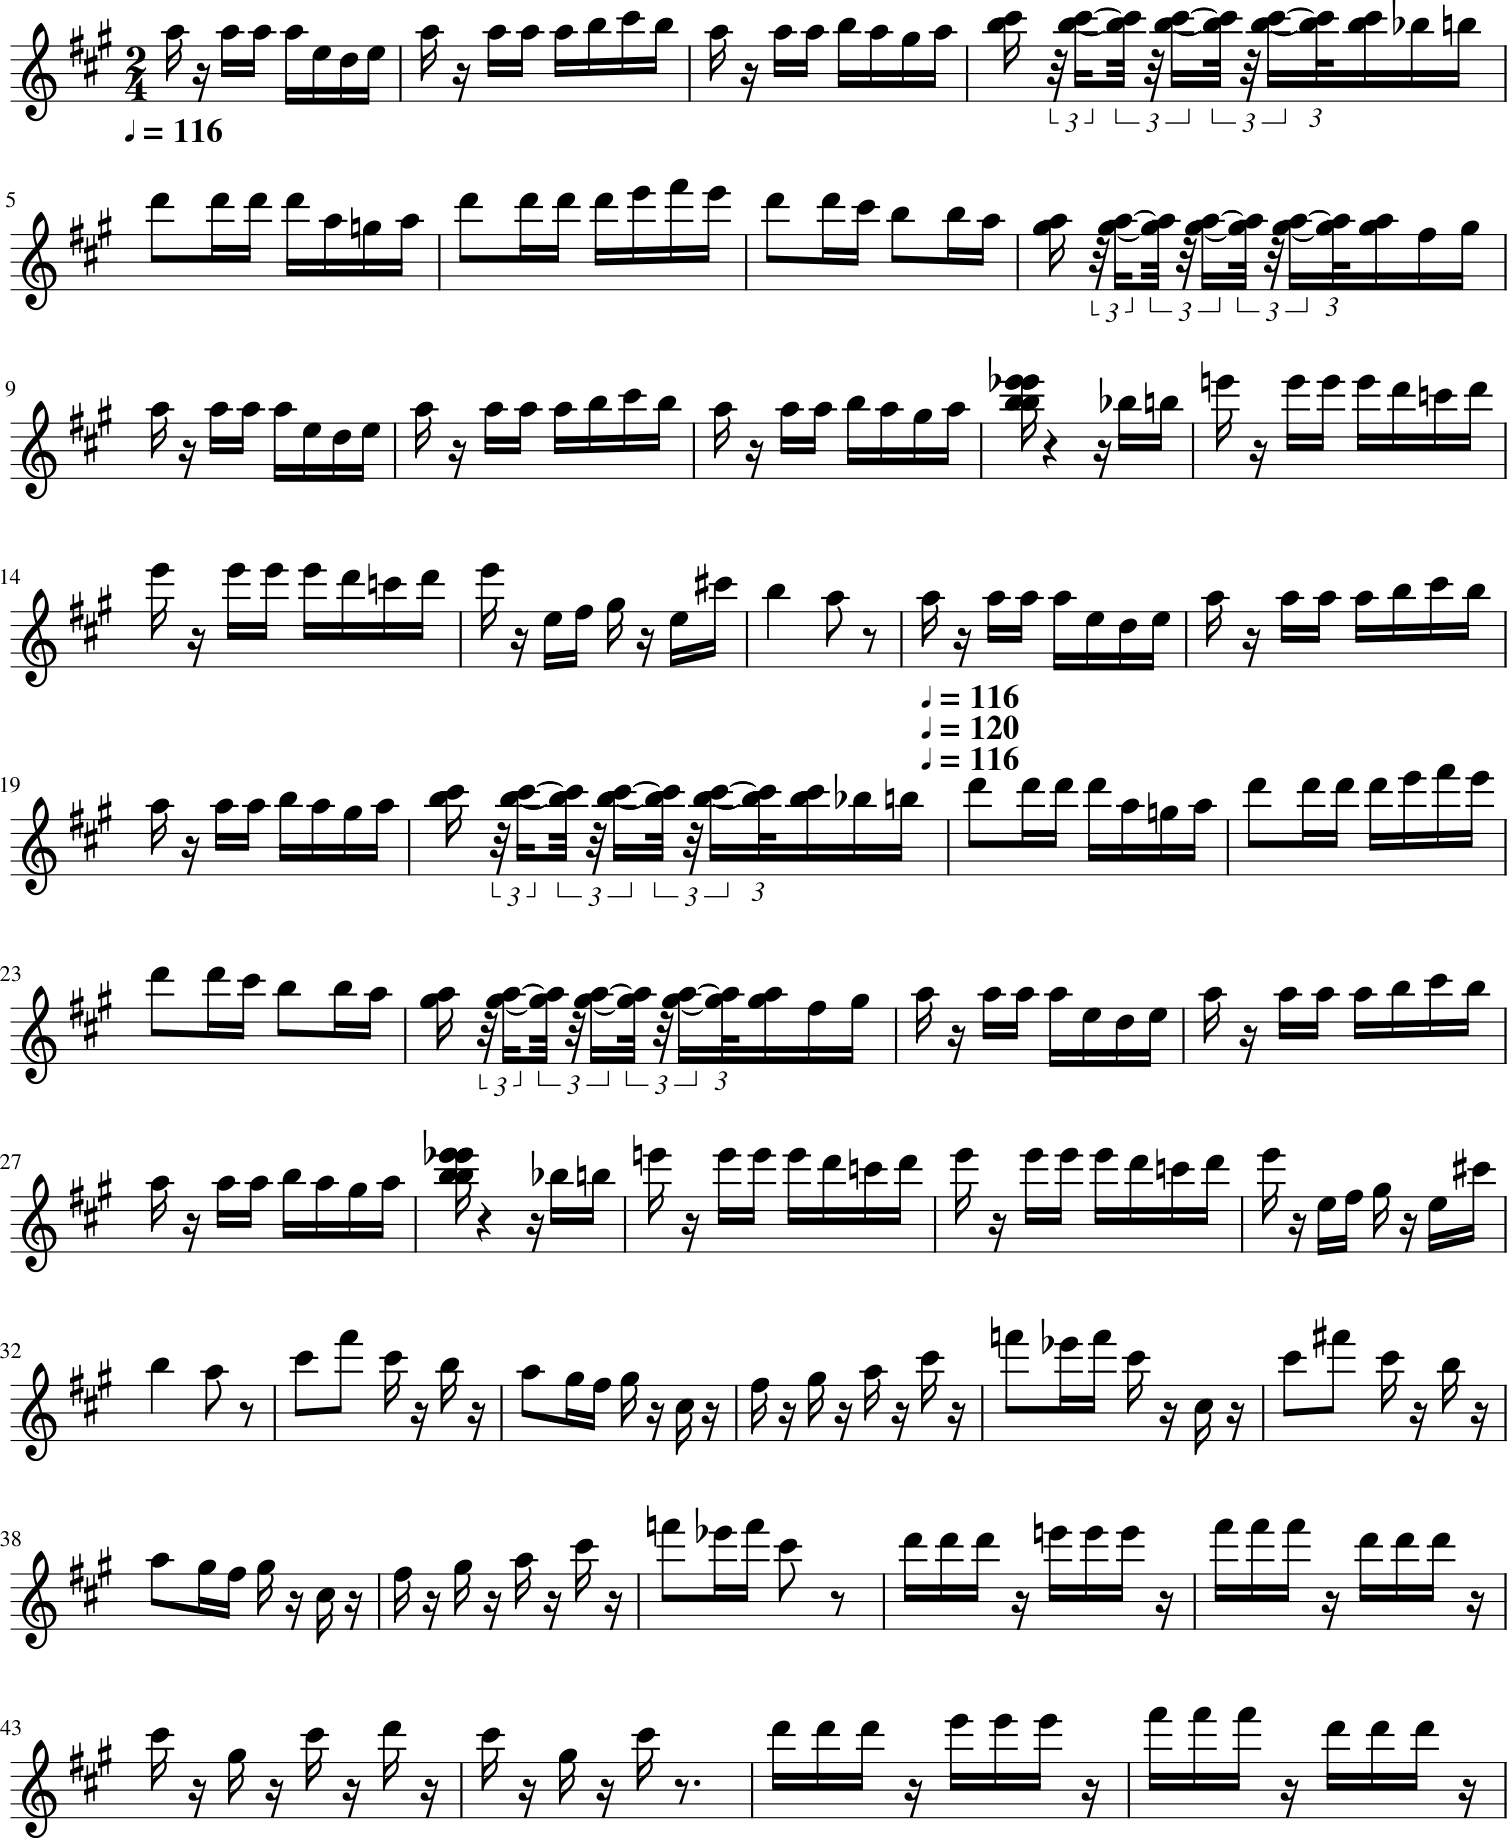

In [63]:
aux.parts[0].show()

In [62]:
aux.parts[0].show("midi")

In [17]:
parts = []
for part in aux.parts:
       parts.append(part.flat) #or just parts.append(part), as you wish.

In [19]:
parts[0].show("text")

{0.0} <music21.instrument.Flute 'Flute'>
{0.0} <music21.clef.TrebleClef>
{0.0} <music21.tempo.MetronomeMark Quarter=116.0>
{0.0} <music21.key.Key of A major>
{0.0} <music21.meter.TimeSignature 2/4>
{0.0} <music21.note.Note A>
{0.25} <music21.note.Rest 16th>
{0.5} <music21.note.Note A>
{0.75} <music21.note.Note A>
{1.0} <music21.note.Note A>
{1.25} <music21.note.Note E>
{1.5} <music21.note.Note D>
{1.75} <music21.note.Note E>
{2.0} <music21.note.Note A>
{2.25} <music21.note.Rest 16th>
{2.5} <music21.note.Note A>
{2.75} <music21.note.Note A>
{3.0} <music21.note.Note A>
{3.25} <music21.note.Note B>
{3.5} <music21.note.Note C#>
{3.75} <music21.note.Note B>
{4.0} <music21.note.Note A>
{4.25} <music21.note.Rest 16th>
{4.5} <music21.note.Note A>
{4.75} <music21.note.Note A>
{5.0} <music21.note.Note B>
{5.25} <music21.note.Note A>
{5.5} <music21.note.Note G#>
{5.75} <music21.note.Note A>
{6.0} <music21.chord.Chord B5 C#6>
{6.25} <music21.note.Rest 1/12ql>
{6.3333} <music21.chord.Chord B5 C#6>


In [86]:
list(parts[0].notes)[6].nameWithOctave

<music21.note.Note A>

In [12]:
notas = [n for n in list(aux.parts)[0].flat.notes]

# Convertir cada nota a su nombre y duración
notas_convertidas = [midi_note_to_name_dur(n) for n in notas]


In [13]:
notas_convertidas

[('A5', 0.25),
 ('A5', 0.25),
 ('A5', 0.25),
 ('A5', 0.25),
 ('E5', 0.25),
 ('D5', 0.25),
 ('E5', 0.25),
 ('A5', 0.25),
 ('A5', 0.25),
 ('A5', 0.25),
 ('A5', 0.25),
 ('B5', 0.25),
 ('C#6', 0.25),
 ('B5', 0.25),
 ('A5', 0.25),
 ('A5', 0.25),
 ('A5', 0.25),
 ('B5', 0.25),
 ('A5', 0.25),
 ('G#5', 0.25),
 ('A5', 0.25),
 (['B5', 'C#6'], [1.0, 1.0]),
 (['B5', 'C#6'], [1.0, 1.0]),
 (['B5', 'C#6'], [1.0, 1.0]),
 (['B5', 'C#6'], [1.0, 1.0]),
 (['B5', 'C#6'], [1.0, 1.0]),
 ('B-5', 0.25),
 ('B5', 0.25),
 ('D6', 0.5),
 ('D6', 0.25),
 ('D6', 0.25),
 ('D6', 0.25),
 ('A5', 0.25),
 ('G5', 0.25),
 ('A5', 0.25),
 ('D6', 0.5),
 ('D6', 0.25),
 ('D6', 0.25),
 ('D6', 0.25),
 ('E6', 0.25),
 ('F#6', 0.25),
 ('E6', 0.25),
 ('D6', 0.5),
 ('D6', 0.25),
 ('C#6', 0.25),
 ('B5', 0.5),
 ('B5', 0.25),
 ('A5', 0.25),
 (['G#5', 'A5'], [1.0, 1.0]),
 (['G#5', 'A5'], [1.0, 1.0]),
 (['G#5', 'A5'], [1.0, 1.0]),
 (['G#5', 'A5'], [1.0, 1.0]),
 (['G#5', 'A5'], [1.0, 1.0]),
 ('F#5', 0.25),
 ('G#5', 0.25),
 ('A5', 0.25),
 ('A5',

In [14]:
score = music21.stream.Score()

# Create the melody part and add notes to it
melody_part = music21.stream.Part()
ts0 = music21.meter.TimeSignature('2/4')
melody_part.append(music21.tempo.MetronomeMark(number=116))
melody_part.append(ts0)
for note_name, duration in notas_convertidas:
    if not isinstance(note_name,list):
        melody_note = music21.note.Note(note_name, quarterLength=duration)
    else:
        melody_note = music21.chord.Chord(note_name, quarterLength=duration[0])
    melody_part.append(melody_note)

# Append parts to the score
score.append(melody_part)

In [15]:
score.show("midi")

In [41]:
flute_part=list(music21.instrument.partitionByInstrument(aux).parts)[0]

In [72]:
k = flute_part.analyze('key')
i = music21.interval.Interval(k.tonic, pitch.Pitch('C'))
sNew = flute_part.transpose(i)

In [74]:
sNew.show("midi")

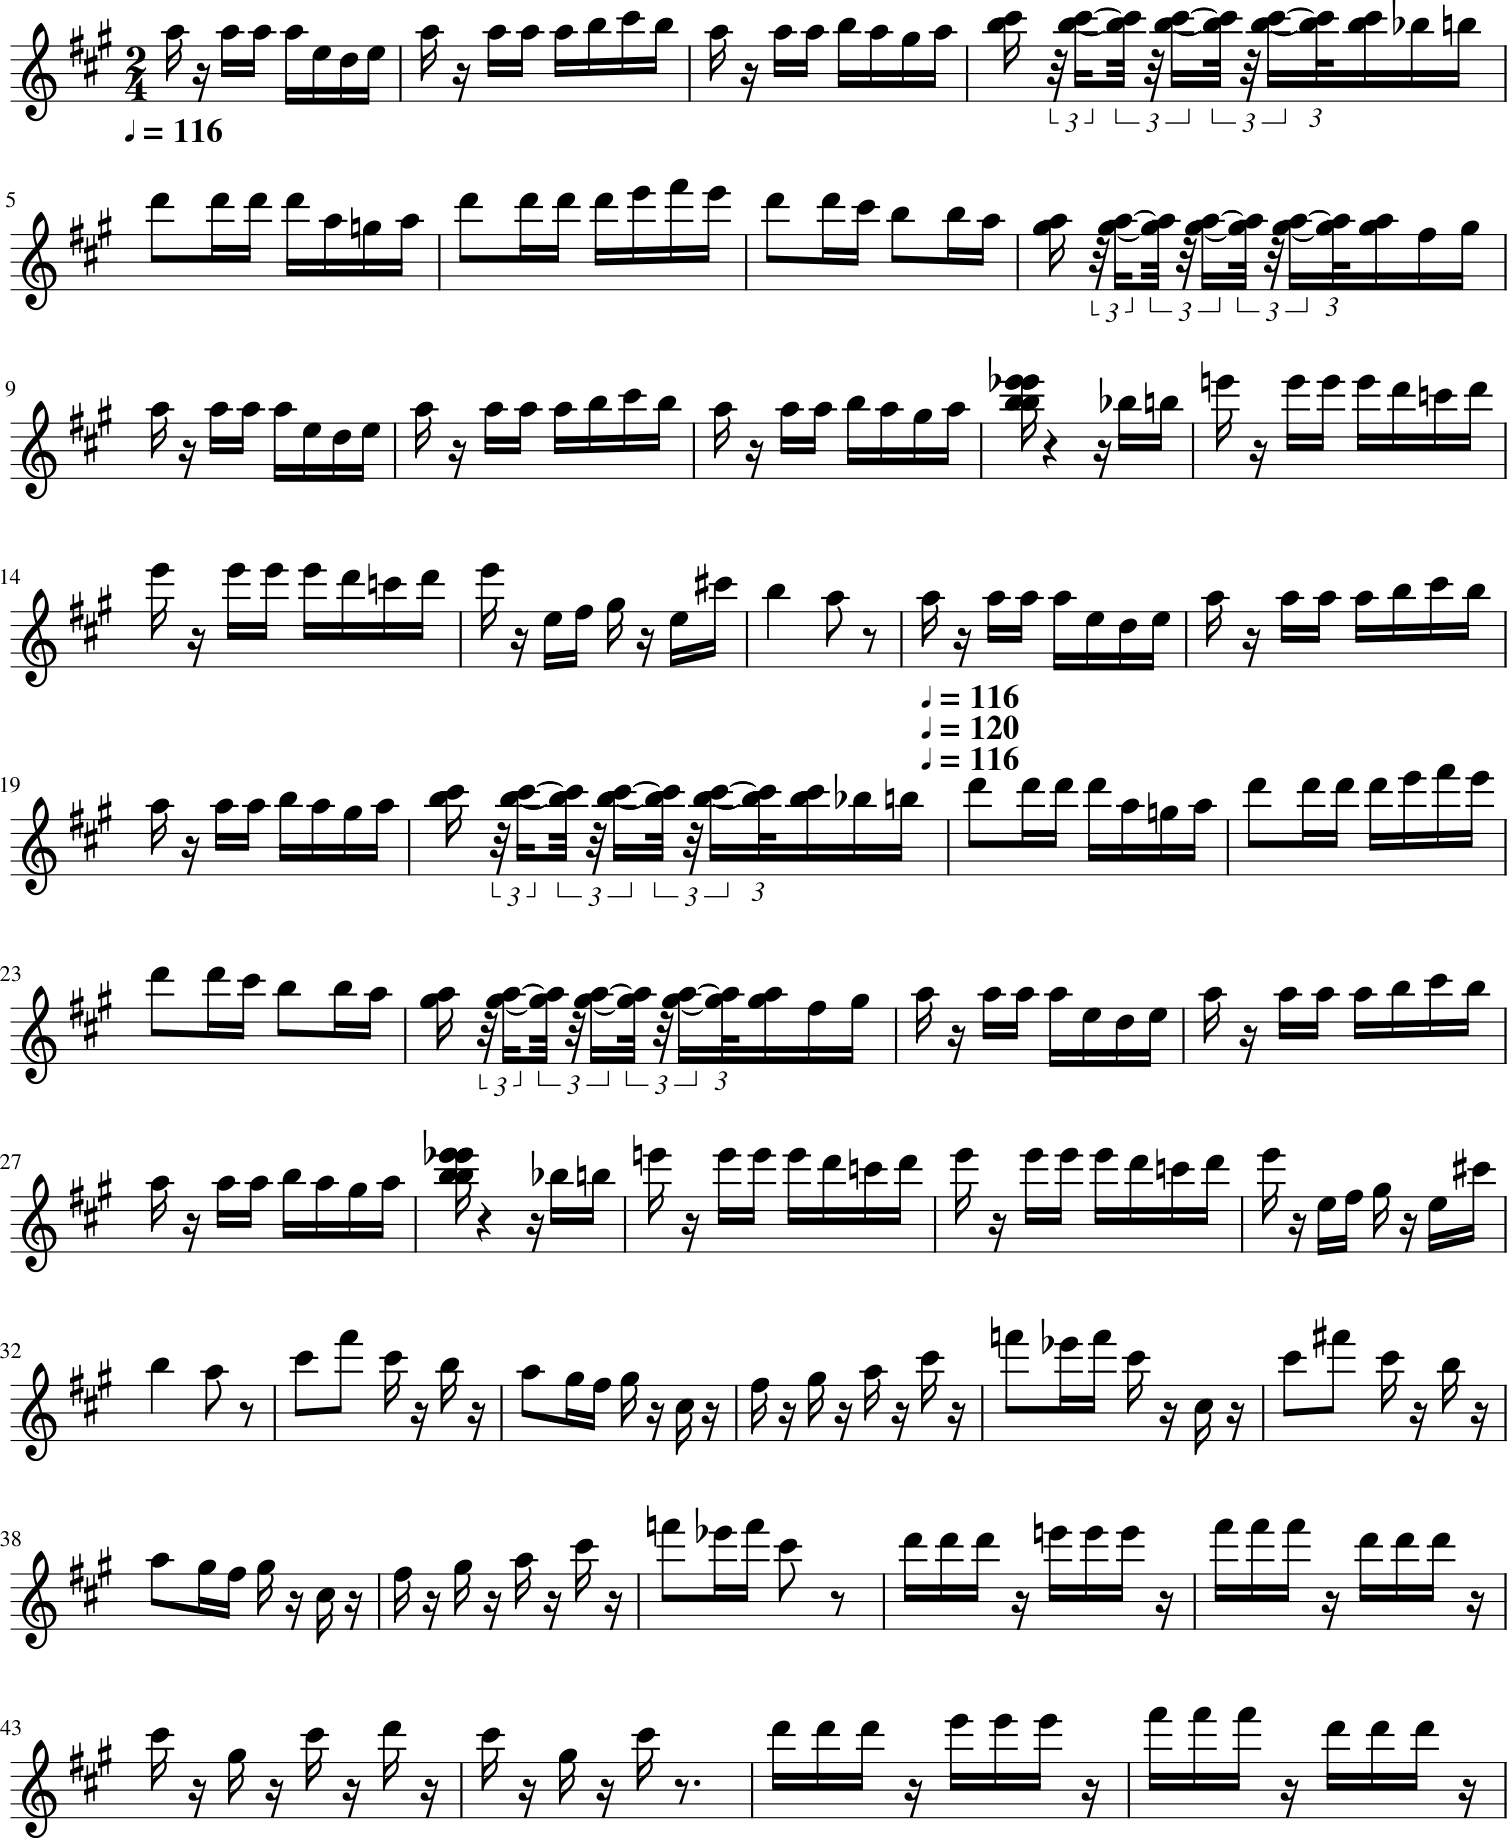

In [52]:
flute_part.flatten().show()

In [75]:
[i.duration for i in list(sNew.notes) if i]

[<music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.Duration 0.25>,
 <music21.duration.D

In [126]:
# Encontrar la parte de la flauta
for elemento in aux.getElementsByClass(music21.stream.Part):
    print(elemento.id)
    if elemento.getElementsByClass(music21.instrument.Flute):
        print(elemento.getElementsByClass(music21.instrument.Flute))
        parte_flauta = elemento
        break

140057373779712
140057371454096
140057369096736
140057366737344
140057363532624
140057361774144
140057360197472
140057358573632
140057355924816
140057353425440
140057351851744
140057350498528
140057348203760
140057347916944
140057347104976
140057343132288
140057339522544
140057336326464
140057333908000


In [111]:
list(aux.Parts[0].getElementsByClass(music21.instrument.Instrument))

AttributeError: 'Score' object has no attribute 'Parts'

In [76]:
# Extraer las notas del archivo MIDI
stream = midi.translate.midiFileToStream(mf)
notas = [n for n in sNew.flat.notes]

# Convertir cada nota a su nombre y duración
notas_convertidas = [midi_note_to_name_dur(n) for n in notas]

# Imprimir las notas convertidas
for nota in notas_convertidas:
    print(nota)

/home/arturo/miniconda3/envs/music/lib/python3.8/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Fl\xfbte'>; getting generic Instrument
  warnings.warn(


('C5', 0.25)
('C5', 0.25)
('C5', 0.25)
('C5', 0.25)
('G4', 0.25)
('F4', 0.25)
('G4', 0.25)
('C5', 0.25)
('C5', 0.25)
('C5', 0.25)
('C5', 0.25)
('D5', 0.25)
('E5', 0.25)
('D5', 0.25)
('C5', 0.25)
('C5', 0.25)
('C5', 0.25)
('D5', 0.25)
('C5', 0.25)
('B4', 0.25)
('C5', 0.25)
(['D5', 'E5'], [1.0, 1.0])
(['D5', 'E5'], [1.0, 1.0])
(['D5', 'E5'], [1.0, 1.0])
(['D5', 'E5'], [1.0, 1.0])
(['D5', 'E5'], [1.0, 1.0])
('C#5', 0.25)
('D5', 0.25)
('F5', 0.5)
('F5', 0.25)
('F5', 0.25)
('F5', 0.25)
('C5', 0.25)
('B-4', 0.25)
('C5', 0.25)
('F5', 0.5)
('F5', 0.25)
('F5', 0.25)
('F5', 0.25)
('G5', 0.25)
('A5', 0.25)
('G5', 0.25)
('F5', 0.5)
('F5', 0.25)
('E5', 0.25)
('D5', 0.5)
('D5', 0.25)
('C5', 0.25)
(['B4', 'C5'], [1.0, 1.0])
(['B4', 'C5'], [1.0, 1.0])
(['B4', 'C5'], [1.0, 1.0])
(['B4', 'C5'], [1.0, 1.0])
(['B4', 'C5'], [1.0, 1.0])
('A4', 0.25)
('B4', 0.25)
('C5', 0.25)
('C5', 0.25)
('C5', 0.25)
('C5', 0.25)
('G4', 0.25)
('F4', 0.25)
('G4', 0.25)
('C5', 0.25)
('C5', 0.25)
('C5', 0.25)
('C5', 0.25)
('D5

In [94]:
print([x.getInstrument().instrumentName for x in stream])

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [82]:
notas[7].getInstrument()


<music21.instrument.BassDrum 'Bass Drum'>

In [73]:
print(dir(notas[7]))

['_DOC_ATTR', '_DOC_ORDER', '__annotations__', '__class__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_activeSite', '_activeSiteStoredOffset', '_cache', '_chordAttached', '_classSetCacheDict', '_classTupleCacheDict', '_deepcopySubclassable', '_derivation', '_duration', '_editorial', '_getActiveSite', '_getLyric', '_getMeasureOffset', '_getPriority', '_getSeconds', '_getStemDirection', '_getStoredInstrument', '_getTimeSignatureForBeat', '_getVolume', '_id', '_naiveOffset', '_notehead', '_noteheadFill', '_noteheadParenthesis', '_priority', '_reprInternal', '_reprText', '_reprTextLine', '_setActiveSite', '_setLyric', '_setPriority', '_setSecond

In [208]:
# Convertir cada nota a su nombre y duración
notas_convertidas = [midi_note_to_name_dur(n) for n in notas]

# Imprimir las notas convertidas
for nota in notas_convertidas:
    print(nota)

AttributeError: 'tuple' object has no attribute 'duration'

--- 

In [176]:
import pretty_midi
notas=[]
midi_data = pretty_midi.PrettyMIDI('./data-MIDI/_2022_09_19_Bizet_Carmen_Prelude.mid',initial_tempo=116)


In [203]:
notas=[]
tempo=midi_data.estimate_tempo()
print(tempo)
duracion_beat = 60.0 / tempo
for i in midi_data.instruments[0].notes:
    notas.append((pretty_midi.note_number_to_name(i.pitch),  round(i.get_duration()/duracion_beat/0.2230940391146502/4 ,3)))

207.03142012143687


In [204]:
notas

[('A5', 0.5),
 ('A5', 0.25),
 ('A5', 0.25),
 ('A5', 0.25),
 ('E5', 0.25),
 ('D5', 0.25),
 ('E5', 0.25),
 ('A5', 0.5),
 ('A5', 0.25),
 ('A5', 0.25),
 ('A5', 0.25),
 ('B5', 0.25),
 ('C#6', 0.25),
 ('B5', 0.25),
 ('A5', 0.5),
 ('A5', 0.25),
 ('A5', 0.25),
 ('B5', 0.25),
 ('A5', 0.25),
 ('G#5', 0.25),
 ('A5', 0.25),
 ('B5', 0.281),
 ('C#6', 0.267),
 ('B5', 0.258),
 ('C#6', 0.25),
 ('B5', 0.235),
 ('C#6', 0.219),
 ('B5', 0.227),
 ('C#6', 0.244),
 ('B5', 0.25),
 ('C#6', 0.244),
 ('A#5', 0.508),
 ('B5', 0.469),
 ('D6', 1.0),
 ('D6', 0.5),
 ('D6', 0.5),
 ('D6', 0.5),
 ('A5', 0.5),
 ('G5', 0.5),
 ('A5', 0.5),
 ('D6', 1.0),
 ('D6', 0.5),
 ('D6', 0.5),
 ('D6', 0.5),
 ('E6', 0.5),
 ('F#6', 0.5),
 ('E6', 0.5),
 ('D6', 1.0),
 ('D6', 0.5),
 ('C#6', 0.5),
 ('B5', 1.0),
 ('B5', 0.5),
 ('A5', 0.5),
 ('G#5', 0.281),
 ('A5', 0.267),
 ('G#5', 0.258),
 ('A5', 0.25),
 ('G#5', 0.235),
 ('A5', 0.219),
 ('G#5', 0.227),
 ('A5', 0.244),
 ('G#5', 0.25),
 ('A5', 0.244),
 ('F#5', 0.508),
 ('G#5', 0.469),
 ('A5', 0.5

In [205]:
score = music21.stream.Score()
ts0 = music21.meter.TimeSignature('2/4')

melody_part = music21.stream.Part()
melody_part.append(ts0)
for note_name, duration in notas:
    melody_note = music21.note.Note(note_name, quarterLength=duration)
    melody_part.append(melody_note)


score.append(melody_part)


In [206]:
score.show("midi")

In [175]:
print("duration:",midi_data.get_end_time())
print(f'{"note":>10} {"start":>10} {"end":>10}')
for instrument in midi_data.instruments:
    #print("instrument:", instrument.program);
    for i,note in enumerate(instrument.notes):
        if (pretty_midi.note_number_to_name(note.pitch)=="A#1"):
            print(i)
        notas.append(pretty_midi.note_number_to_name(note.pitch))
        #print(f'{pretty_midi.note_number_to_name(note.pitch)} {round(note.get_duration()/0.13,2)}')

duration: 139.65507
      note      start        end
107
108


In [66]:
midi_data.instruments

[Instrument(program=73, is_drum=False, name="Flûte"),
 Instrument(program=72, is_drum=False, name="Piccolo"),
 Instrument(program=68, is_drum=False, name="Hautbois 1-2"),
 Instrument(program=71, is_drum=False, name="Clarinettes 1-2 en La"),
 Instrument(program=70, is_drum=False, name="Basson 1-2"),
 Instrument(program=60, is_drum=False, name="Corns 1-2 en La"),
 Instrument(program=60, is_drum=False, name="Corns 3-4  en Mi"),
 Instrument(program=56, is_drum=False, name="Trompette 1-2 en LA"),
 Instrument(program=57, is_drum=False, name="Trombones 1-2"),
 Instrument(program=57, is_drum=False, name="Trombone 3"),
 Instrument(program=47, is_drum=False, name="Timbales"),
 Instrument(program=0, is_drum=True, name="Triangle"),
 Instrument(program=0, is_drum=True, name="Grosse Caisse "),
 Instrument(program=0, is_drum=True, name="Cymbales"),
 Instrument(program=48, is_drum=False, name="Violons I"),
 Instrument(program=48, is_drum=False, name="Violons II"),
 Instrument(program=48, is_drum=False

In [43]:
import numpy as np
import pandas as pd 

In [48]:
np.argwhere(notas=="A#1")

array([], shape=(0, 0), dtype=int64)

In [47]:
print(pd.DataFrame(np.unique(notas,return_counts=True)))

    0    1    2    3    4    5   6    7    8    9   ...   63   64   65   66  \
0  A#1  A#2  A#3  A#4  A#5  A#6  A1   A2   A3   A4  ...  G#3  G#4  G#5  G#6   
1    2   10   54   65   54   12  11  149  403  638  ...  161  290  228  176   

   67  68  69   70  71  72  
0  G1  G2  G3   G4  G5  G6  
1  12  38  93  187  87   9  

[2 rows x 73 columns]


In [25]:
midi_data.instruments[0].notes

[Note(start=0.000000, end=0.129310, pitch=81, velocity=120),
 Note(start=0.258621, end=0.323276, pitch=81, velocity=113),
 Note(start=0.387931, end=0.452586, pitch=81, velocity=113),
 Note(start=0.517241, end=0.581896, pitch=81, velocity=113),
 Note(start=0.646551, end=0.711206, pitch=76, velocity=111),
 Note(start=0.775861, end=0.840517, pitch=74, velocity=110),
 Note(start=0.905172, end=0.969827, pitch=76, velocity=111),
 Note(start=1.034482, end=1.163792, pitch=81, velocity=121),
 Note(start=1.293103, end=1.357758, pitch=81, velocity=114),
 Note(start=1.422413, end=1.487068, pitch=81, velocity=114),
 Note(start=1.551723, end=1.616378, pitch=81, velocity=114),
 Note(start=1.681033, end=1.745688, pitch=83, velocity=115),
 Note(start=1.810344, end=1.874999, pitch=85, velocity=117),
 Note(start=1.939654, end=2.004309, pitch=83, velocity=115),
 Note(start=2.068964, end=2.198274, pitch=81, velocity=121),
 Note(start=2.327584, end=2.392240, pitch=81, velocity=114),
 Note(start=2.456895, en

In [3]:
# set up  
twinkle_twinkle_melody = [
    ("C5", 1),
    ("C5", 1),
    ("G5", 1),
    ("G5", 1),
    ("A5", 1),
    ("A5", 1),
    ("G5", 2),  # Twinkle, twinkle, little star,
    ("F5", 1),
    ("F5", 1),
    ("E5", 1),
    ("E5", 1),
    ("D5", 1),
    ("D5", 1),
    ("C5", 2),  # How I wonder what you are!
    ("G5", 1),
    ("G5", 1),
    ("F5", 1),
    ("F5", 1),
    ("E5", 1),
    ("E5", 1),
    ("D5", 2),  # Up above the world so high,
    ("G5", 1),
    ("G5", 1),
    ("F5", 1),
    ("F5", 1),
    ("E5", 1),
    ("E5", 1),
    ("D5", 2),  # Like a diamond in the sky.
    ("C5", 1),
    ("C5", 1),
    ("G5", 1),
    ("G5", 1),
    ("A5", 1),
    ("A5", 1),
    ("G5", 2),  # Twinkle, twinkle, little star,
    ("F5", 1),
    ("F5", 1),
    ("E5", 1),
    ("E5", 1),
    ("D5", 1),
    ("D5", 1),
    ("C5", 2)  # How I wonder what you are!
]
weights = {
    "chord_melody_congruence": 0.4,
    "chord_variety": 0.1,
    "harmonic_flow": 0.3,
    "functional_harmony": 0.2
}
chord_mappings = {
    "C": ["C", "E", "G"],
    "Dm": ["D", "F", "A"],
    "Em": ["E", "G", "B"],
    "F": ["F", "A", "C"],
    "G": ["G", "B", "D"],
    "Am": ["A", "C", "E"],
    "Bdim": ["B", "D", "F"]
}
preferred_transitions = {
    "C": ["G", "Am", "F"],
    "Dm": ["G", "Am"],
    "Em": ["Am", "F"],
    "F": ["C", "G"],
    "G": ["Am", "C"],
    "Am": ["Dm", "Em", "F"],
    "Bdim": ["C", "F", "Am"]
}
# mejor prefered_progressions

In [ ]:
scale=[]

In [ ]:
# Instantiate objects for generating harmonization
melody_data = MelodyData(twinkle_twinkle_melody)
fitness_evaluator = FitnessEvaluator(
    melody_data=melody_data,
    weights=weights,
    chord_mappings=chord_mappings,
    preferred_transitions=preferred_transitions,
)
harmonizer = GeneticMelodyHarmonizer(
    melody_data=melody_data,
    chords=list(chord_mappings.keys()),
    population_size=100,
    mutation_rate=0.05,
    fitness_evaluator=fitness_evaluator,
)



In [ ]:
# Generate chords with genetic algorithm
generated_chords = harmonizer.generate(generations=1000)

# Render to music21 score and show it
music21_score = create_score(
    twinkle_twinkle_melody, generated_chords, chord_mappings
)
music21_score.show()